Saving Electricity_Price_Data_by_Date_and_Year.csv to Electricity_Price_Data_by_Date_and_Year (1).csv
Loading data...
Running Monte Carlo simulation...
Calculating densities...
Results exported to simulated_paths_with_probabilities.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating plot...
Chart saved as electricity_price_simulation.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

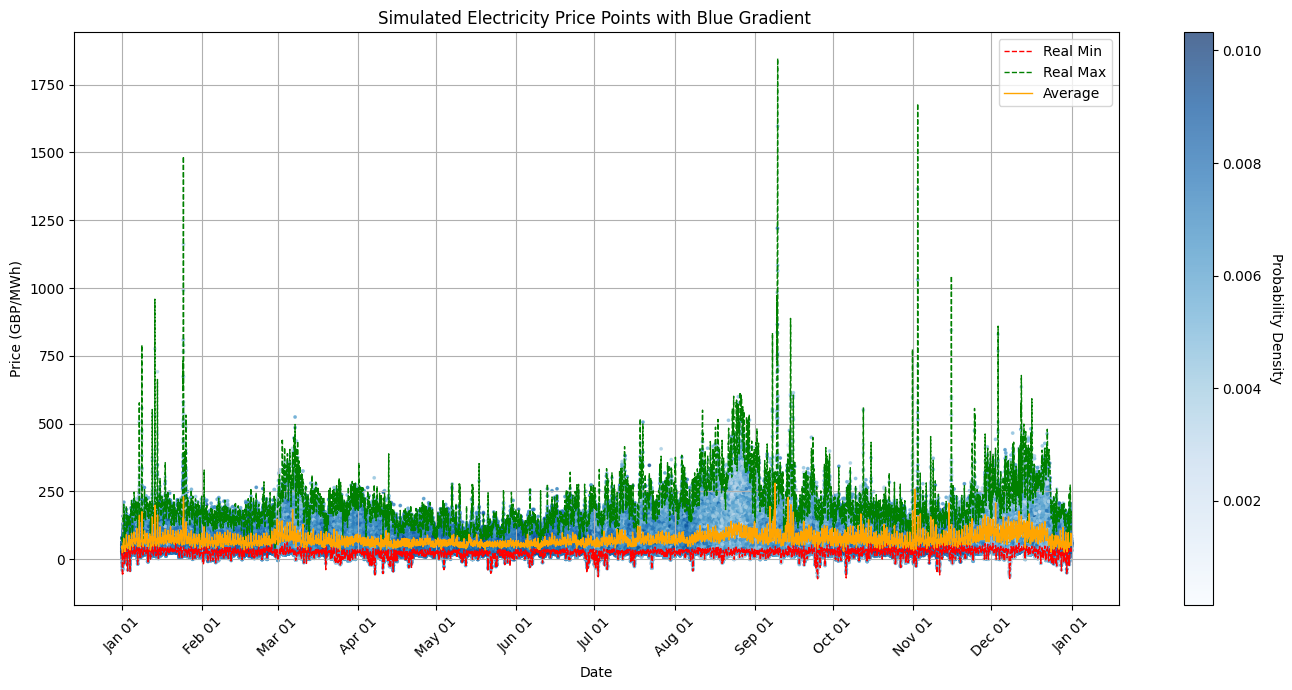

Total runtime: 475.39 seconds


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from scipy.stats import gaussian_kde
from google.colab import files
import time

start_time = time.time()

# 上传数据文件
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# 加载数据
print("Loading data...")
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

# 计算全年每小时的均值、标准差、历史最大最小值
means = data['Average_variable']
stds = data.iloc[:, 1:-2].std(axis=1)
real_min = data.iloc[:, 1:-2].min(axis=1)
real_max = data.iloc[:, 1:-2].max(axis=1)

# 设置模拟参数
num_simulations = 20
exceedance_limit = 0.1

# 执行蒙特卡洛模拟
print("Running Monte Carlo simulation...")
simulated_values = np.random.normal(loc=means.values[:, np.newaxis],
                                    scale=stds.values[:, np.newaxis],
                                    size=(len(means), num_simulations))
simulated_values = np.clip(simulated_values,
                           real_min.values[:, np.newaxis] * (1 - exceedance_limit),
                           real_max.values[:, np.newaxis] * (1 + exceedance_limit))

# 计算概率密度
print("Calculating densities...")
kde = gaussian_kde(simulated_values.flatten())
densities = kde(simulated_values.flatten()).reshape(simulated_values.shape)

# 创建结果DataFrame
result_df = pd.DataFrame(simulated_values, columns=[f'Path_{i+1}' for i in range(num_simulations)])
result_df['Date'] = data['Date']
result_df['Density'] = densities.mean(axis=1)
result_df = result_df.melt(id_vars=['Date', 'Density'], var_name='Path', value_name='Price')

# 导出结果到CSV
output_file = 'simulated_paths_with_probabilities.csv'
result_df.to_csv(output_file, index=False)
print(f"Results exported to {output_file}")

# 提供下载链接（如果在Google Colab中运行）
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    print(f"File saved locally as {output_file}")

# 可视化
print("Generating plot...")
plt.figure(figsize=(14, 7))

cmap = plt.cm.Blues
cmap.set_under('white')
norm = mcolors.Normalize(vmin=result_df['Density'].min(), vmax=result_df['Density'].max())

# 首先绘制散点图
scatter = plt.scatter(result_df['Date'], result_df['Price'],
                      c=result_df['Density'],
                      cmap=cmap,
                      norm=norm,
                      s=3,
                      alpha=0.7,
                      zorder=1)

# 然后绘制最大值、最小值和均值线
plt.plot(data['Date'], real_min, color='red', linestyle='--', label='Real Min', linewidth=1, zorder=2)
plt.plot(data['Date'], real_max, color='green', linestyle='--', label='Real Max', linewidth=1, zorder=2)
plt.plot(data['Date'], means, color='orange', linestyle='-', label='Average', linewidth=1, zorder=2)

# 设置x轴日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

cbar = plt.colorbar(scatter)
cbar.set_label('Probability Density', rotation=270, labelpad=15)

plt.title('Simulated Electricity Price Points with Blue Gradient ')
plt.xlabel('Date')
plt.ylabel('Price (GBP/MWh)')  # 添加价格单位
plt.xticks(rotation=45)
plt.grid(True, zorder=0)
plt.legend()

plt.tight_layout()

# 保存图表
chart_file = 'electricity_price_simulation.png'
plt.savefig(chart_file, dpi=300, bbox_inches='tight')
print(f"Chart saved as {chart_file}")

# 如果在Google Colab中运行，提供图表下载链接
try:
    from google.colab import files
    files.download(chart_file)
except ImportError:
    print(f"Chart saved locally as {chart_file}")

plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")